# Detección de anomalías

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers.core import Dense 
from keras.models import Model, Sequential
from keras import regularizers

C:\Users\ayfdcp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Carga de datos del fichero 'df_rolling_3d.pkl'

In [2]:
df = pd.read_pickle('df_rolling_3d.pkl')
ROLLING_DAYS = 3

## Construcción del dataset

In [3]:
# Inclusión de features a partir de los valores de 'ProblemReported' y de la ventana de tiempo de 3 días definida:
#     - Feature 'Problem': por cada día con 'ProblemReported' = 1, etiquetamos dicho día y los 2 días anteriores.
#     - Feature 'DaysTo': días restantes hasta el siguiente 'ProblemReported'. Tras el último, se fijará a -1.
for device in df.DeviceID.unique():
    reported_array = df.loc[(df.DeviceID == device), 'ProblemReported'].values
    reported_array = reported_array[::-1]             # Recorreremos el vector al contrario, facilitando la implementación
    problem_array = np.zeros(len(reported_array))
    daysto_array = np.zeros(len(reported_array))
    problem_found = False                             # Flag para diferenciar el periodo en el que rellenar 'DaysTo' con -1
    
    for i in range(len(reported_array)):
    
        if not problem_found:
            daysto_array[i] = -1                      # Rellenamos 'DaysTo' con -1 mientras no encontremos el último problema
        else:
            daysto_array[i] = daysto_array[i - 1] + 1 # Incrementamos 'DaysTo' mientras no encontremos otro problema anterior
        
        if reported_array[i] == 1:                    # Encontramos un problema y reiniciamos contadores de los arrays
            problem_found = True
            problem_array[i] = 1
            daysto_array[i] = 0
            
            for j in range(i + 1, i + ROLLING_DAYS):  # En adelante al problema reportado, completamos la ventana de rolling
                if j < len(reported_array):           # Evitamos el acceso a un índice fuera de los límites del array
                    problem_array[j] = 1
    
    problem_array = problem_array[::-1]
    df.loc[(df.DeviceID == device), 'Problem'] = problem_array
    
    daysto_array = daysto_array[::-1]
    df.loc[(df.DeviceID == device), 'DaysTo'] = daysto_array

#### A) Conjunto de train y dos de tests para detección de anomalías

In [4]:
# Train sin anomalías: registros con más de 18 meses (540 días) hasta el próximo problema reportado
train_no_anomalies = df.loc[(df.DaysTo >= 540)]
print(train_no_anomalies.shape)

# Test sin anomalías: registros diferentes a los del conjunto de train
test_no_anomalies = df.loc[(df.DaysTo >= 530) & (df.DaysTo < 540)]
print(test_no_anomalies.shape)

# Test con anomalías
test_anomalies = df.loc[(df.ProblemReported == 1)]
print(test_anomalies.shape)

(105366, 351)
(4773, 351)
(3984, 351)


In [5]:
# Eliminación de features con poca variabilidad (desviación estándar < 0.01), nada útiles para modelar
df_A = pd.concat([train_no_anomalies, test_no_anomalies, test_anomalies], ignore_index=True)
low_std = {}

for column in df_A.columns:
    try:
        if df_A[column].std() < 0.01:
            low_std[column] = df_A[column].std()
    except:
        None

df_A = df_A.drop([k for k in low_std.keys()], axis=1)

# Tomar features escaladas, que sirvan al autoencoder.
features = ['ProblemReported', 'DaysTo']
features.extend([feature for feature in df_A.columns if 'Error_' in feature and len(feature) == 13])
features.extend([feature for feature in df_A.columns if 'Fault_' in feature and len(feature) == 23])
features.extend([feature for feature in df_A.columns if 'Problem_' in feature and len(feature) == 26])
features.extend([feature for feature in df_A.columns if 'Warning_' in feature and len(feature) == 26])
features.extend([feature for feature in df_A.columns if 'AE_' in feature and len(feature) == 17])

df_A = df_A[features]
print(df_A.shape)

(114123, 17)


In [6]:
# Train sin anomalías: registros con más de 18 meses (540 días) hasta el próximo problema reportado
train_no_anomalies = df_A.loc[(df_A.DaysTo >= 540)]
train_no_anomalies = train_no_anomalies.drop(['ProblemReported', 'DaysTo'], axis=1)
print(train_no_anomalies.shape)

# Test sin anomalías: registros diferentes a los del conjunto de train
test_no_anomalies = df_A.loc[(df_A.DaysTo >= 530) & (df_A.DaysTo < 540)]
test_no_anomalies = test_no_anomalies.drop(['ProblemReported', 'DaysTo'], axis=1)
print(test_no_anomalies.shape)

# Test con anomalías
test_anomalies = df_A.loc[(df_A.ProblemReported == 1)]
test_anomalies = test_anomalies.drop(['ProblemReported', 'DaysTo'], axis=1)
print(test_anomalies.shape)

(105366, 15)
(4773, 15)
(3984, 15)


In [156]:
# Modelo de detección de anomalías mediante un AutoEncoder
seed = 2019
np.random.seed(seed)

act_func = 'relu'

model = Sequential()
model.add(Dense(10, input_dim=train_no_anomalies.shape[1], activation=act_func,
                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(2,activation=act_func, kernel_initializer='glorot_uniform'))
model.add(Dense(10,activation=act_func, kernel_initializer='glorot_uniform'))
model.add(Dense(train_no_anomalies.shape[1], kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='nadam')

NUM_EPOCHS = 30
BATCH_SIZE = 10

history = model.fit(train_no_anomalies, train_no_anomalies, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.05)

Train on 100097 samples, validate on 5269 samples
Epoch 1/30
100097/100097 [==============================] - 10s 100us/step - loss: 0.0017 - val_loss: 4.3012e-04
Epoch 2/30
100097/100097 [==============================] - 9s 90us/step - loss: 0.0011 - val_loss: 3.7041e-04
Epoch 3/30
100097/100097 [==============================] - 9s 90us/step - loss: 9.5808e-04 - val_loss: 2.4887e-04
Epoch 4/30
100097/100097 [==============================] - 9s 91us/step - loss: 8.3517e-04 - val_loss: 1.9046e-04
Epoch 5/30
100097/100097 [==============================] - 9s 91us/step - loss: 7.9249e-04 - val_loss: 1.7794e-04
Epoch 6/30
100097/100097 [==============================] - 9s 91us/step - loss: 7.7362e-04 - val_loss: 1.8929e-04
Epoch 7/30
100097/100097 [==============================] - 9s 90us/step - loss: 7.6950e-04 - val_loss: 1.9448e-04
Epoch 8/30
100097/100097 [==============================] - 9s 90us/step - loss: 7.5757e-04 - val_loss: 1.8678e-04
Epoch 9/30
100097/100097 [==========

(0, 30)

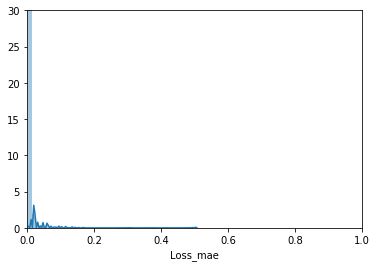

In [163]:
# Distribución de la función de pérdida en el conjunto de train
X_pred = model.predict(train_no_anomalies)
X_pred = pd.DataFrame(X_pred, columns=train_no_anomalies.columns, index=train_no_anomalies.index)

scored = pd.DataFrame(index=train_no_anomalies.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred - train_no_anomalies), axis=1)
plt.figure()
sns.distplot(scored['Loss_mae'])
plt.xlim([0, 1])
plt.ylim([0, 30])

(0, 30)

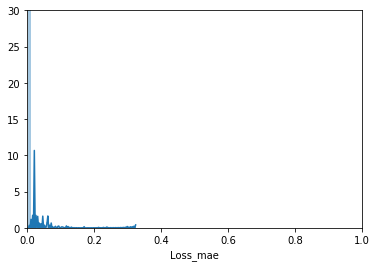

In [164]:
# Predicción en el conjunto de test sin anomalías
X_pred2 = model.predict(test_no_anomalies)
X_pred2 = pd.DataFrame(X_pred2, columns=test_no_anomalies.columns, index=test_no_anomalies.index)

scored2 = pd.DataFrame(index=test_no_anomalies.index)
scored2['Loss_mae'] = np.mean(np.abs(X_pred2 - test_no_anomalies), axis=1)
scored2['Threshold'] = scored.quantile(0.99)[0]
scored2['Anomaly'] = scored2['Loss_mae'] > scored2['Threshold']

plt.figure()
sns.distplot(scored2['Loss_mae'])
plt.xlim([0, 1])
plt.ylim([0, 30])

In [165]:
# Specificity: VN / N reales
acc2 = scored2.loc[scored2.Anomaly == False].shape[0] / scored2.shape[0]
print('Proporción de VN en el conjunto de test sin anomalías:', round(acc2, 2))

Proporción de VN en el conjunto de test sin anomalías: 0.99


(0, 30)

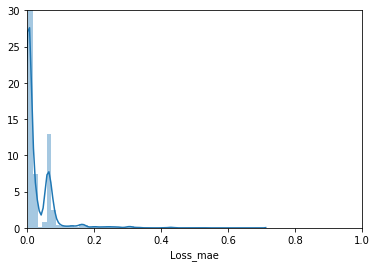

In [166]:
# Predicción en el conjunto de test con anomalías
X_pred3 = model.predict(test_anomalies)
X_pred3 = pd.DataFrame(X_pred3, columns=test_anomalies.columns, index=test_anomalies.index)

scored3 = pd.DataFrame(index=test_anomalies.index)
scored3['Loss_mae'] = np.mean(np.abs(X_pred3 - test_anomalies), axis=1)
scored3['Threshold'] = scored.quantile(0.99)[0]
scored3['Anomaly'] = scored3['Loss_mae'] > scored3['Threshold']

plt.figure()
sns.distplot(scored3['Loss_mae'])
plt.xlim([0, 1])
plt.ylim([0, 30])

In [167]:
# Recall o Sensitivity: VP / P reales
acc3 = scored3.loc[scored3.Anomaly == True].shape[0] / scored3.shape[0]
print('Proporción de VP en el conjunto de test con anomalías:', round(acc3, 2))

Proporción de VP en el conjunto de test con anomalías: 0.27


In [168]:
# Precision: VP / P etiquetados = VP / (VP + FP)
fp_pred2 = scored2.shape[0] - (acc2 * scored2.shape[0])
vp_pred3 = acc3 * scored3.shape[0]

prob_vp = vp_pred3 / (fp_pred2 + vp_pred3)
print('Precisión (proporción de VP entre el total de Positivos etiquetados):', round(prob_vp, 2))

Precisión (proporción de VP entre el total de Positivos etiquetados): 0.95


In [170]:
# Guardamos el modelo y los datasets
import pickle
import os

try:
    os.mkdir('Anomaly Detection')
except:
    None

pickle.dump(model, open('./Anomaly Detection/autoencoder_model.sav', 'wb'))

train_no_anomalies.to_pickle('./Anomaly Detection/train_no_anomalies.pkl')
test_no_anomalies.to_pickle('./Anomaly Detection/test_no_anomalies.pkl')
test_anomalies.to_pickle('./Anomaly Detection/test_anomalies.pkl')